__This notebook comes from sklearn documentation - I just added some extra explanations__

## Partial Dependence (PDP) and Individual Conditional Expectation (ICE) Plots

Partial dependence plots show the dependence between the target function
and a set of features of interest, marginalizing over the values of all other
features (the complement features). Due to the limits of human perception, the
size of the set of features of interest must be small (usually, one or two)
thus they are usually chosen among the most important features.

Similarly, an individual conditional expectation (ICE) plot
shows the dependence between the target function and a feature of interest.
However, unlike partial dependence plots, which show the average effect of the
features of interest, ICE plots visualize the dependence of the prediction on a
feature for each `sample` separately, with one line per sample.
Only one feature of interest is supported for ICE plots.

## Bike sharing dataset preprocessing

We will use the bike sharing dataset. The goal is to predict the number of bike
rentals using weather and season data as well as the datetime information.



In [1]:
from sklearn.datasets import fetch_openml

bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
# Make an explicit copy to avoid "SettingWithCopyWarning" from pandas
X, y = bikes.data.copy(), bikes.target

# We use only a subset of the data to speed up the example.
X = X.iloc[::5, :]
y = y[::5]

The feature `"weather"` has a particularity: the category `"heavy_rain"` is a rare
category.



In [2]:
X["weather"].value_counts()

clear         2284
misty          904
rain           287
heavy_rain       1
Name: weather, dtype: int64

Because of this rare category, we collapse it into `"rain"`.



In [3]:
X["weather"] = (
    X["weather"]
    .astype(object)
    .replace(to_replace="heavy_rain", value="rain")
    .astype("category")
)

We now have a closer look at the `"year"` feature:



In [4]:
X["year"].value_counts()

1    1747
0    1729
Name: year, dtype: int64

We see that we have data from two years. We use the first year to train the
model and the second year to test the model.



In [5]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

We can check the dataset information to see that we have heterogeneous data types. We
have to preprocess the different columns accordingly.



In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1729 entries, 0 to 8640
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      1729 non-null   category
 1   month       1729 non-null   int64   
 2   hour        1729 non-null   int64   
 3   holiday     1729 non-null   category
 4   weekday     1729 non-null   int64   
 5   workingday  1729 non-null   category
 6   weather     1729 non-null   category
 7   temp        1729 non-null   float64 
 8   feel_temp   1729 non-null   float64 
 9   humidity    1729 non-null   float64 
 10  windspeed   1729 non-null   float64 
dtypes: category(4), float64(4), int64(3)
memory usage: 115.4 KB


From the previous information, we will consider the `category` columns as nominal
categorical features. In addition, we will consider the date and time information as
categorical features as well.

We manually define the columns containing numerical and categorical
features.



In [7]:
numerical_features = [
    "temp",
    "feel_temp",
    "humidity",
    "windspeed",
]
categorical_features = X_train.columns.drop(numerical_features)

Before we go into the details regarding the preprocessing of the different machine
learning pipelines, we will try to get some additional intuition regarding the dataset
that will be helpful to understand the model's statistical performance and results of
the partial dependence analysis.

We plot the average number of bike rentals by grouping the data by season and
by year.



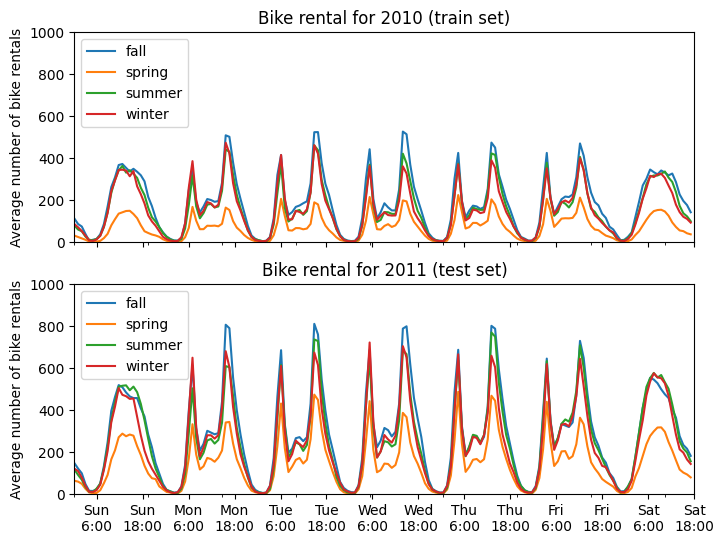

In [8]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

days = ("Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat")
hours = tuple(range(24))
xticklabels = [f"{day}\n{hour}:00" for day, hour in product(days, hours)]
xtick_start, xtick_period = 6, 12

fig, axs = plt.subplots(nrows=2, figsize=(8, 6), sharey=True, sharex=True)
average_bike_rentals = bikes.frame.groupby(
    ["year", "season", "weekday", "hour"],
    observed=True).mean(numeric_only=True)["count"]
for ax, (idx, df) in zip(axs, average_bike_rentals.groupby("year")):
    df.groupby("season", observed=True).plot(ax=ax, legend=True)

    # decorate the plot
    ax.set_xticks(
        np.linspace(
            start=xtick_start,
            stop=len(xticklabels),
            num=len(xticklabels) // xtick_period,
        ))
    ax.set_xticklabels(xticklabels[xtick_start::xtick_period])
    ax.set_xlabel("")
    ax.set_ylabel("Average number of bike rentals")
    ax.set_title(
        f"Bike rental for {'2010 (train set)' if idx == 0.0 else '2011 (test set)'}"
    )
    ax.set_ylim(0, 1_000)
    ax.set_xlim(0, len(xticklabels))
    ax.legend(loc=2)

The first striking difference between the train and test set is that the number of
bike rentals is higher in the test set. For this reason, it will not be surprising to
get a machine learning model that underestimates the number of bike rentals. We
also observe that the number of bike rentals is lower during the spring season. In
addition, we see that during working days, there is a specific pattern around 6-7
am and 5-6 pm with some peaks of bike rentals. We can keep in mind these different
insights and use them to understand the partial dependence plot.

## Preprocessor for machine-learning models

Since we later use two different models, a
`MLPRegressor` and a `HistGradientBoostingRegressor`, we create two different
preprocessors, specific for each model.

### Preprocessor for the neural network model

We will use a `QuantileTransformer` to scale the
numerical features and encode the categorical features with a
`OneHotEncoder`.

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer

mlp_preprocessor = ColumnTransformer(transformers=[
    ("num", QuantileTransformer(n_quantiles=100), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])
mlp_preprocessor

ColumnTransformer(transformers=[('num', QuantileTransformer(n_quantiles=100),
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'))])

### Preprocessor for the gradient boosting model

For the gradient boosting model, we leave the numerical features as-is and only
encode the categorical features using a
:class:`OrdinalEncoder`.



In [10]:
from sklearn.preprocessing import OrdinalEncoder

hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
hgbdt_preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat', OrdinalEncoder(),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object')),
                                ('num', 'passthrough',
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed'])],
                  verbose_feature_names_out=False)

## 1-way partial dependence with different models

In this section, we will compute 1-way partial dependence with two different
machine-learning models: (i) a multi-layer perceptron and (ii) a
gradient-boosting model. With these two models, we illustrate how to compute and
interpret both partial dependence plot (PDP) for both numerical and categorical
features and individual conditional expectation (ICE).

### Multi-layer perceptron

Let's fit a `MLPRegressor` and compute
single-variable partial dependence plots.

In [11]:
from time import time

from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

print("Training MLPRegressor...")
tic = time()
mlp_model = make_pipeline(
    mlp_preprocessor,
    MLPRegressor(
        hidden_layer_sizes=(30, 15),
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=0,
    ),
)
mlp_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {mlp_model.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 0.193s
Test R2 score: 0.61


We configured a pipeline using the preprocessor that we created specifically for the
neural network and tuned the neural network size and learning rate to get a reasonable
compromise between training time and predictive performance on a test set.

Importantly, this tabular dataset has very different dynamic ranges for its
features. Neural networks tend to be very sensitive to features with varying
scales and forgetting to preprocess the numeric feature would lead to a very
poor model.

It would be possible to get even higher predictive performance with a larger
neural network but the training would also be significantly more expensive.

Note that it is important to check that the model is accurate enough on a
test set before plotting the partial dependence since there would be little
use in explaining the impact of a given feature on the prediction function of
a model with poor predictive performance. In this regard, our MLP model works
reasonably well.

We will plot the averaged partial dependence.



Computing partial dependence plots...
done in 1.128s


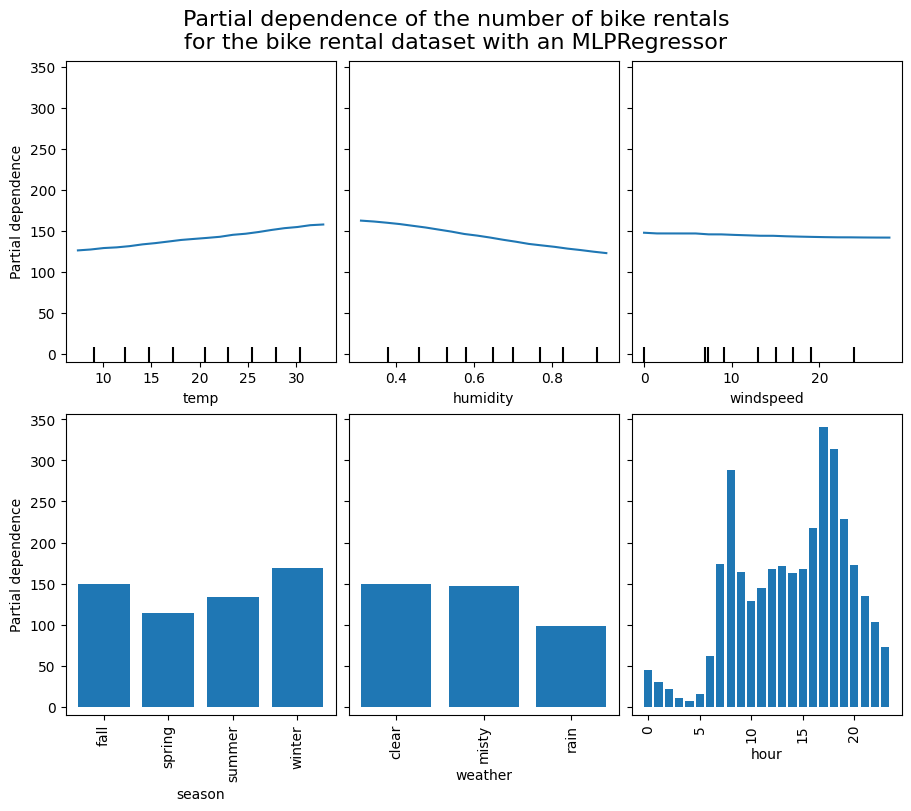

In [12]:
import matplotlib.pyplot as plt

from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": ["temp", "humidity", "windspeed", "season", "weather", "hour"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    mlp_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    ("Partial dependence of the number of bike rentals\n"
     "for the bike rental dataset with an MLPRegressor"),
    fontsize=16,
)

### Gradient boosting

Let's now fit a `HistGradientBoostingRegressor` and
compute the partial dependence on the same features. We also use the
specific preprocessor we created for this model.

In [13]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
hgbdt_model = make_pipeline(
    hgbdt_preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=categorical_features,
        random_state=0,
        max_iter=50,
    ),
)
hgbdt_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {hgbdt_model.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 0.215s
Test R2 score: 0.62


Here, we used the default hyperparameters for the gradient boosting model
without any preprocessing as tree-based models are naturally robust to
monotonic transformations of numerical features.

Note that on this tabular dataset, Gradient Boosting Machines are both
significantly faster to train and more accurate than neural networks. It is
also significantly cheaper to tune their hyperparameters (the defaults tend
to work well while this is not often the case for neural networks).

We will plot the partial dependence for some of the numerical and categorical
features.



Computing partial dependence plots...
done in 0.410s


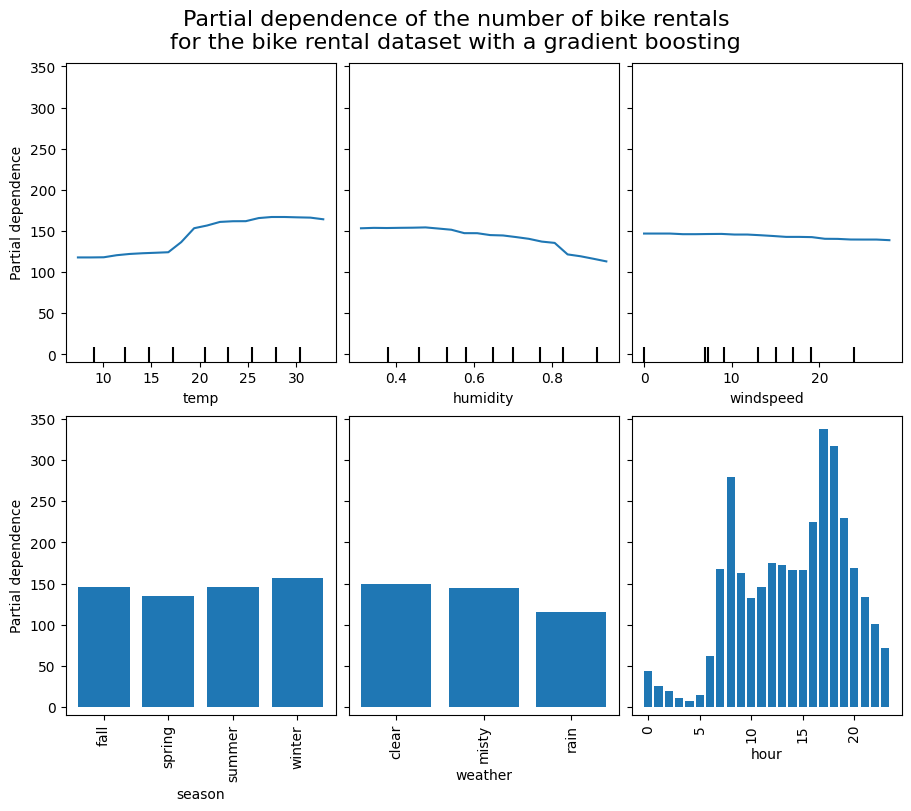

In [14]:
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    ("Partial dependence of the number of bike rentals\n"
     "for the bike rental dataset with a gradient boosting"),
    fontsize=16,
)

### Analysis of the plots

We will first look at the PDPs for the numerical features. For both models, the
general trend of the PDP of the temperature is that the number of bike rentals is
increasing with temperature. We can make a similar analysis but with the opposite
trend for the humidity features. The number of bike rentals is decreasing when the
humidity increases. Finally, we see the same trend for the wind speed feature. The
number of bike rentals is decreasing when the wind speed is increasing for both
models. We also observe that :class:`~sklearn.neural_network.MLPRegressor` has much
smoother predictions than :class:`~sklearn.ensemble.HistGradientBoostingRegressor`.

Now, we will look at the partial dependence plots for the categorical features.

We observe that the spring season is the lowest bar for the season feature. With the
weather feature, the rain category is the lowest bar. Regarding the hour feature,
we see two peaks around the 7 am and 6 pm. These findings are in line with the
the observations we made earlier on the dataset.

However, it is worth noting that we are creating potential meaningless
synthetic samples if features are correlated.

### ICE vs. PDP
PDP is an average of the marginal effects of the features. We are averaging the
response of all samples of the provided set. Thus, some effects could be hidden. In
this regard, it is possible to plot each individual response. This representation is
called the Individual Effect Plot (ICE). In the plot below, we plot 50 randomly
selected ICEs for the temperature and humidity features.



Computing partial dependence plots and individual conditional expectation...
done in 0.234s


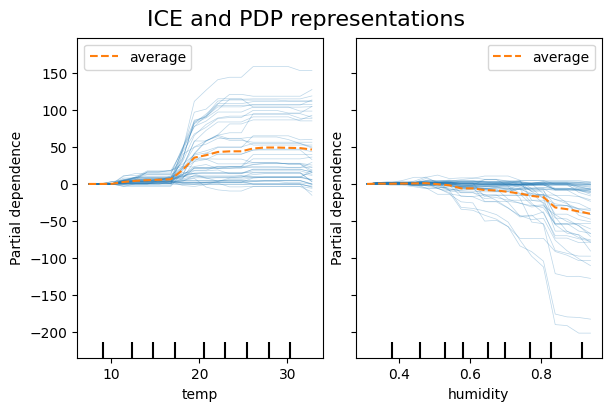

In [15]:
print(
    "Computing partial dependence plots and individual conditional expectation..."
)
tic = time()
_, ax = plt.subplots(ncols=2,
                     figsize=(6, 4),
                     sharey=True,
                     constrained_layout=True)

features_info = {
    "features": ["temp", "humidity"],
    "kind": "both",
    "centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

We see that the ICE for the temperature feature gives us some additional information:
Some of the ICE lines are flat while some others show a decrease of the dependence
for temperature above 35 degrees Celsius. We observe a similar pattern for the
humidity feature: some of the ICEs lines show a sharp decrease when the humidity is
above 80%.

Not all ICE lines are parallel, this indicates that the model finds
interactions between features. We can repeat the experiment by constraining the
gradient boosting model to not use any interactions between features using the
parameter `interaction_cst`:



In [16]:
from sklearn.base import clone

interaction_cst = [[i] for i in range(X_train.shape[1])]
hgbdt_model_without_interactions = (clone(hgbdt_model).set_params(
    histgradientboostingregressor__interaction_cst=interaction_cst).fit(
        X_train, y_train))
print(
    f"Test R2 score: {hgbdt_model_without_interactions.score(X_test, y_test):.2f}"
)

Test R2 score: 0.38


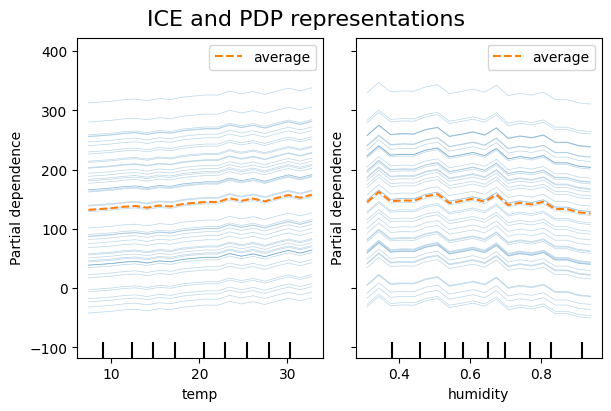

In [17]:
_, ax = plt.subplots(ncols=2,
                     figsize=(6, 4),
                     sharey=True,
                     constrained_layout=True)

features_info["centered"] = False
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model_without_interactions,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

## 2D interaction plots

PDPs with two features of interest enable us to visualize interactions among them.
However, ICEs cannot be plotted in an easy manner and thus interpreted. We will show
the representation of available in
:meth:`~sklearn.inspection.PartialDependenceDisplay.from_estimator` that is a 2D
heatmap.



Computing partial dependence plots...
done in 1.923s


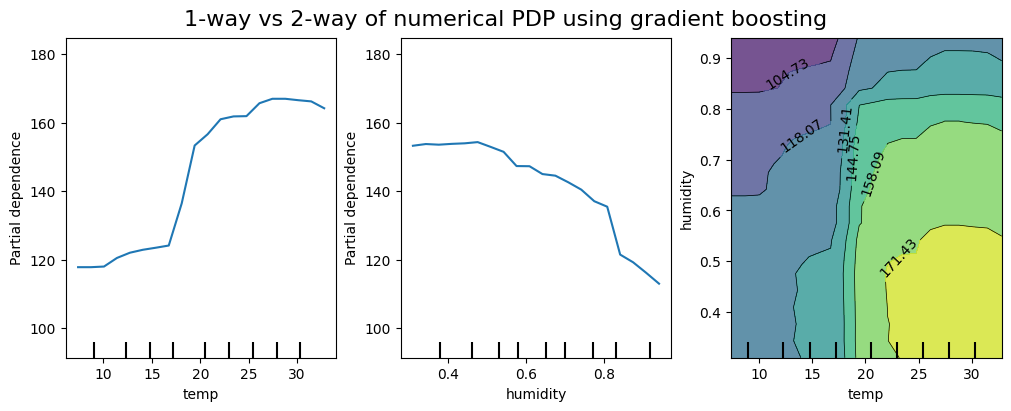

In [18]:
print("Computing partial dependence plots...")
features_info = {
    "features": ["temp", "humidity", ("temp", "humidity")],
    "kind": "average",
}
_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
tic = time()
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16)

The two-way partial dependence plot shows the dependence of the number of bike rentals
on joint values of temperature and humidity.
We clearly see an interaction between the two features. For a temperature higher than
20 degrees Celsius, the humidity has a impact on the number of bike rentals
that seems independent on the temperature.

On the other hand, for temperatures lower than 20 degrees Celsius, both the
temperature and humidity continuously impact the number of bike rentals.

Furthermore, the slope of the of the impact ridge of the 20 degrees Celsius
threshold is very dependent on the humidity level: the ridge is steep under
dry conditions but much smoother under wetter conditions above 70% of humidity.

We now contrast those results with the same plots computed for the model
constrained to learn a prediction function that does not depend on such
non-linear feature interactions.



Computing partial dependence plots...
done in 1.762s


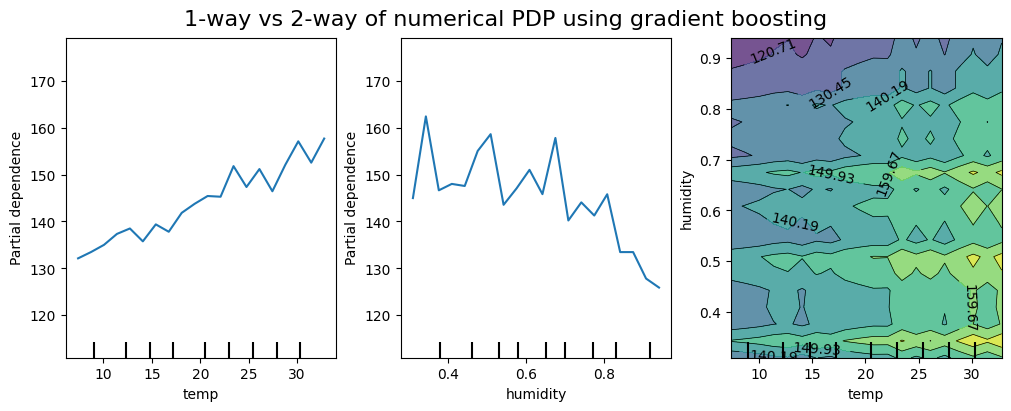

In [19]:
print("Computing partial dependence plots...")
features_info = {
    "features": ["temp", "humidity", ("temp", "humidity")],
    "kind": "average",
}
_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
tic = time()
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model_without_interactions,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16)

The 1D partial dependence plots for the model constrained to not model feature
interactions show local spikes for each features individually, in particular for
for the "humidity" feature. Those spikes might be reflecting a degraded behavior
of the model that attempts to somehow compensate for the forbidden interactions
by overfitting particular training points. Note that the predictive performance
of this model as measured on the test set is significantly worse than that of
the original, unconstrained model.

Also note that the number of local spikes visible on those plots is depends on
the grid resolution parameter of the PD plot itself.

Those local spikes result in a noisily gridded 2D PD plot. It is quite
challenging to tell whether or not there are no interaction between those
features because of the high frequency oscillations in the humidity feature.
However it can clearly be seen that the simple interaction effect observed when
the temperature crosses the 20 degrees boundary is no longer visible for this
model.

The partial dependence between categorical features will provide a discrete
representation that can be shown as a heatmap. For instance the interaction between
the season, the weather, and the target would be as follow:



Computing partial dependence plots...
done in 0.132s


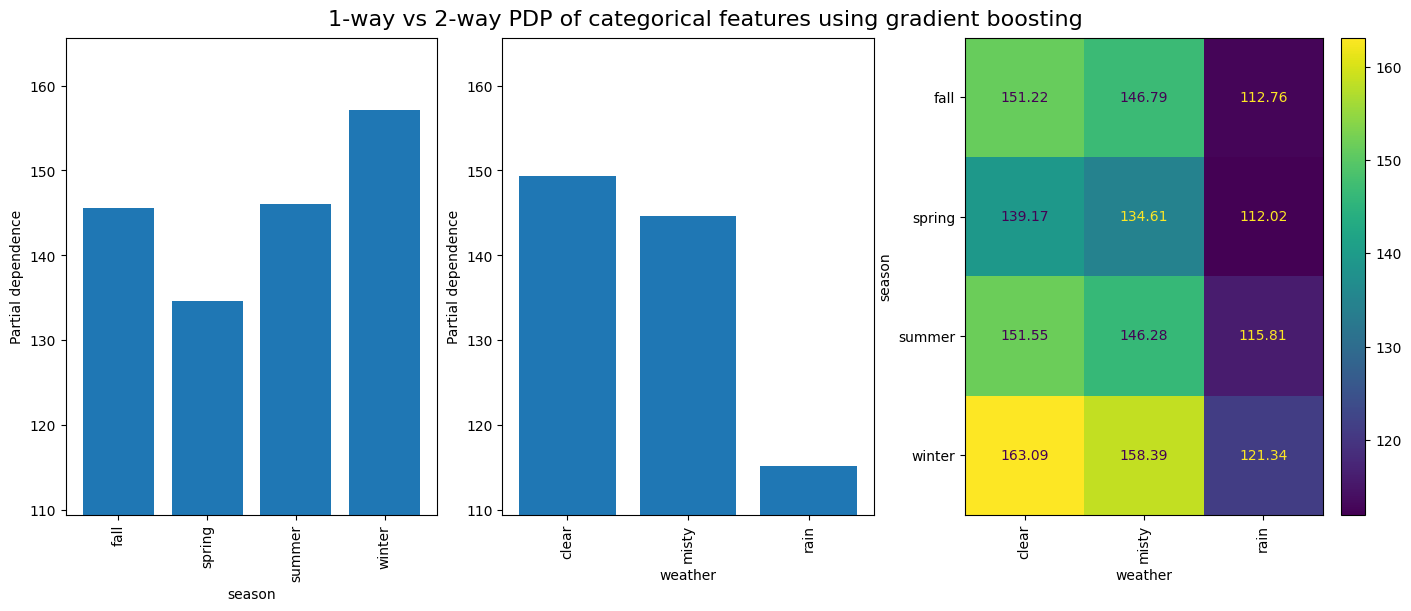

In [20]:
print("Computing partial dependence plots...")
features_info = {
    "features": ["season", "weather", ("season", "weather")],
    "kind": "average",
    "categorical_features": categorical_features,
}
_, ax = plt.subplots(ncols=3, figsize=(14, 6), constrained_layout=True)
tic = time()
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)

print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "1-way vs 2-way PDP of categorical features using gradient boosting",
    fontsize=16)

### 3D representation

Let's make the same partial dependence plot for the 2 features interaction,
this time in 3 dimensions.
unused but required import for doing 3d projections with matplotlib < 3.2



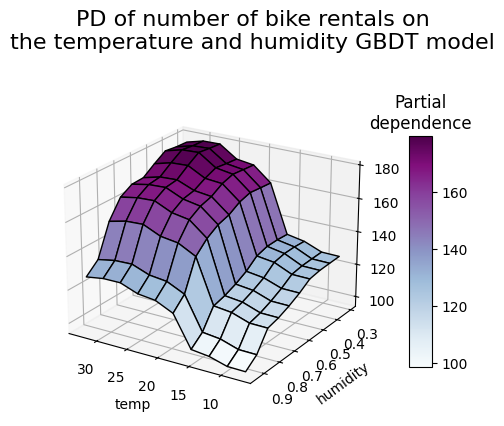

In [22]:
import mpl_toolkits.mplot3d
import numpy as np

from sklearn.inspection import partial_dependence

fig = plt.figure(figsize=(5.5, 5))

features = ("temp", "humidity")
pdp = partial_dependence(hgbdt_model,
                         X_train,
                         features=features,
                         kind="average",
                         grid_resolution=10)
XX, YY = np.meshgrid(pdp["grid_values"][0], pdp["grid_values"][1])
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX,
                       YY,
                       Z,
                       rstride=1,
                       cstride=1,
                       cmap=plt.cm.BuPu,
                       edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle(
    "PDP of number of bike rentals on\nthe temperature and humidity GBDT model",
    fontsize=16,
)
# pretty init view
ax.view_init(elev=22, azim=122)
clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
clb.ax.set_title("Partial\ndependence")
plt.show()